## Последовательное выполнение алгоритма

In [3]:
import optuna
import time
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

Для обучения модели будем использовать только файлы *.ann.features.csv, так как они содержат уже размеченные данные, там есть и признаки и метки.
Объединим данные из файлов:

In [4]:
import pandas as pd
import glob

# Найдем все нужные CSV-файлы
file_paths = glob.glob("data/csh*.ann.features.csv")

# Читаем и объединяем
df_list = [pd.read_csv(file) for file in file_paths]
df_full = pd.concat(df_list, ignore_index=True)

print("Данные объединены.")
print("Форма датафрейма:", df_full.shape)
print("Уникальные активности:", df_full['activity'].unique())

Данные объединены.
Форма датафрейма: (1854095, 37)
Уникальные активности: ['Step_Out' 'Other_Activity' 'Toilet' 'Phone' 'Personal_Hygiene'
 'Leave_Home' 'Enter_Home' 'Relax' 'Sleep_Out_Of_Bed' 'Drink' 'Watch_TV'
 'Dress' 'Evening_Meds' 'Wake_Up' 'Read' 'Morning_Meds' 'Cook_Breakfast'
 'Eat_Breakfast' 'Bathe' 'Cook_Lunch' 'Eat_Lunch' 'Wash_Lunch_Dishes'
 'Go_To_Sleep' 'Sleep' 'Bed_Toilet_Transition' 'Wash_Breakfast_Dishes'
 'Work_At_Table' 'Groom' 'Cook' 'Eat' 'Cook_Dinner' 'Eat_Dinner'
 'Wash_Dinner_Dishes' 'Wash_Dishes' 'Entertain_Guests' 'Take_Medicine'
 'Work' 'Exercise' 'Work_On_Computer' 'Nap']


Разделим данные на признаки и целевую переменную

In [5]:
X = df_full.drop(columns=['activity'])# признаки
y = df_full['activity']# целевая переменная


In [6]:
# Проверка на категориальные признаки
cat_cols = X.select_dtypes(include='object').columns
print("Категориальные признаки:", cat_cols.tolist())

# Проверка пропущенных значений
print(X.isnull().sum())

Категориальные признаки: []
lastSensorEventHours        0
lastSensorEventSeconds      0
lastSensorDayOfWeek         0
windowDuration              0
timeSinceLastSensorEvent    0
prevDominantSensor1         0
prevDominantSensor2         0
lastSensorID                0
lastSensorLocation          0
lastMotionLocation          0
complexity                  0
activityChange              0
areaTransitions             0
numDistinctSensors          0
sensorCount-Bathroom        0
sensorCount-Bedroom         0
sensorCount-Chair           0
sensorCount-DiningRoom      0
sensorCount-Hall            0
sensorCount-Ignore          0
sensorCount-Kitchen         0
sensorCount-LivingRoom      0
sensorCount-Office          0
sensorCount-OutsideDoor     0
sensorCount-WorkArea        0
sensorElTime-Bathroom       0
sensorElTime-Bedroom        0
sensorElTime-Chair          0
sensorElTime-DiningRoom     0
sensorElTime-Hall           0
sensorElTime-Ignore         0
sensorElTime-Kitchen        0
sensorElTime

Есть несколько фреймворков для градиентного бустинга, в нашем случае мы решили выбрать XGBoost, так как в датасете нет пропущенных значений, он более стабилен и дает хорошие возможности для анализа важности признаков

Опишем алгоритм:
1. Модель видит данные X_train (все признаки с датчиков) и y_train (вид активности в доме).
Сначала она строит первое дерево решений, которое делает начальные предсказания — скорее всего неточные.
2. Анализ ошибок
После первого дерева XGBoost сравнивает предсказания с реальными метками, вычисляет ошибку (градиент потерь), на основе ошибок обучает второе дерево, которое будет стараться предсказать именно ошибки первого дерева.
3. Последовательное улучшение
Каждое следующее дерево обучается на ошибках предыдущих деревьев, постепенно улучшает итоговое предсказание, с каждым шагом "команда деревьев" становится умнее.
4. Итоговая модель
В итоге модель состоит из суммы всех деревьев, где каждый кусочек улучшает итоговое предсказание.

Optuna - это быстрая, мощная и гибкая библиотека для оптимизации параметров, она находит лучшие значения параметров, минимизируя ошибку на валидации. Здесь она тестирует 30 разных комбинаций гиперпараметров.

[I 2025-04-15 20:10:04,296] A new study created in memory with name: no-name-615b4f88-67dd-40ce-b6d2-eb7ee639a4ba


Запуск Optuna для подбора гиперпараметров...


[I 2025-04-15 20:11:10,657] Trial 0 finished with value: 0.7453762313195251 and parameters: {'n_estimators': 83, 'max_depth': 5, 'learning_rate': 0.10662742753851664, 'subsample': 0.7549369084194231, 'colsample_bytree': 0.8337106569332935}. Best is trial 0 with value: 0.7453762313195251.
[I 2025-04-15 20:12:45,550] Trial 1 finished with value: 0.8409303719240421 and parameters: {'n_estimators': 105, 'max_depth': 7, 'learning_rate': 0.1261644660161177, 'subsample': 0.8944486114731036, 'colsample_bytree': 0.7123561645444098}. Best is trial 1 with value: 0.8409303719240421.
[I 2025-04-15 20:14:50,481] Trial 2 finished with value: 0.8926926102101203 and parameters: {'n_estimators': 129, 'max_depth': 7, 'learning_rate': 0.18091458773881086, 'subsample': 0.761640546491777, 'colsample_bytree': 0.7894616993275818}. Best is trial 2 with value: 0.8926926102101203.
[I 2025-04-15 20:16:41,576] Trial 3 finished with value: 0.7319899621708679 and parameters: {'n_estimators': 144, 'max_depth': 4, 'le

Лучшие параметры: {'n_estimators': 136, 'max_depth': 7, 'learning_rate': 0.19989625062026506, 'subsample': 0.8481191075386381, 'colsample_bytree': 0.9345361549650195}
Обучение модели с лучшими параметрами...
⏱ Обучение заняло: 570.44 секунд.
Classification Report:
                       precision    recall  f1-score   support

                Bathe       0.98      0.98      0.98      6755
Bed_Toilet_Transition       0.95      0.96      0.95      4136
                 Cook       0.98      0.95      0.96      9776
       Cook_Breakfast       0.96      0.99      0.97     13229
          Cook_Dinner       0.96      0.99      0.97     19024
           Cook_Lunch       0.97      0.98      0.97      8388
                Dress       0.91      0.76      0.83      8722
                Drink       0.95      0.92      0.93      2317
                  Eat       0.98      0.96      0.97      2736
        Eat_Breakfast       0.94      0.95      0.94      4919
           Eat_Dinner       0.97      0.9

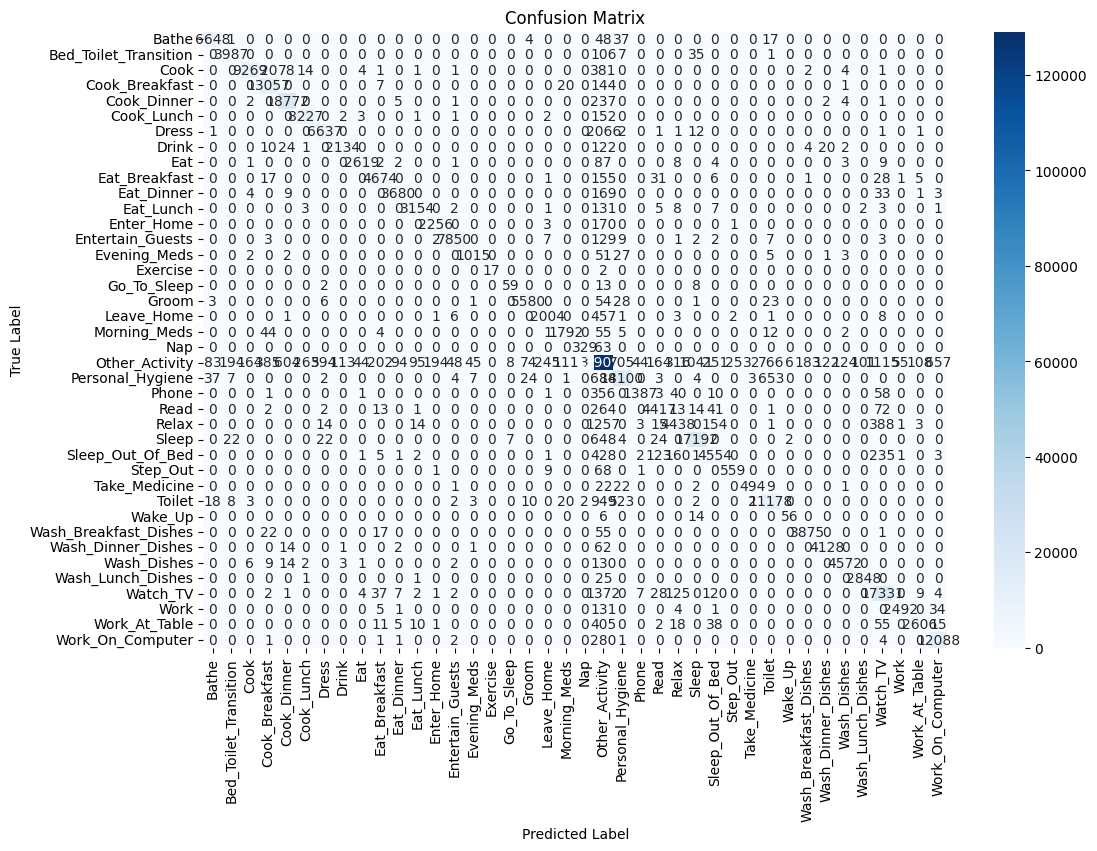

In [7]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# закодируем метки
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# берём часть данных для подбора параметров 
X_optuna, _, y_optuna, _ = train_test_split(
    X_train, y_train, test_size=0.7, stratify=y_train, random_state=42
)

# подбор параметров с помощью Optuna 
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'tree_method': 'hist',
        'use_label_encoder': False,
        'eval_metric': 'mlogloss',
        'n_jobs': -1
    }

    X_sub_train, X_sub_val, y_sub_train, y_sub_val = train_test_split(
        X_optuna, y_optuna, test_size=0.3, stratify=y_optuna, random_state=42
    )

    model = XGBClassifier(**param)
    model.fit(X_sub_train, y_sub_train)
    score = model.score(X_sub_val, y_sub_val)
    return score

print("Запуск Optuna для подбора гиперпараметров...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Лучшие параметры:", study.best_params)

# Обучение на полной тренировочной выборке
best_params = study.best_params
best_params.update({
    'use_label_encoder': False,
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'random_state': 42,
    'n_jobs': -1
})

model = XGBClassifier(**best_params)

print("Обучение модели с лучшими параметрами...")
start = time.time()
model.fit(X_train, y_train)
end = time.time()
print(f"⏱ Обучение заняло: {end - start:.2f} секунд.")

#  Оценка 
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

#  Матрица ошибок 
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


На графике посмотрим, на какие параметры модель опиралась больше всего

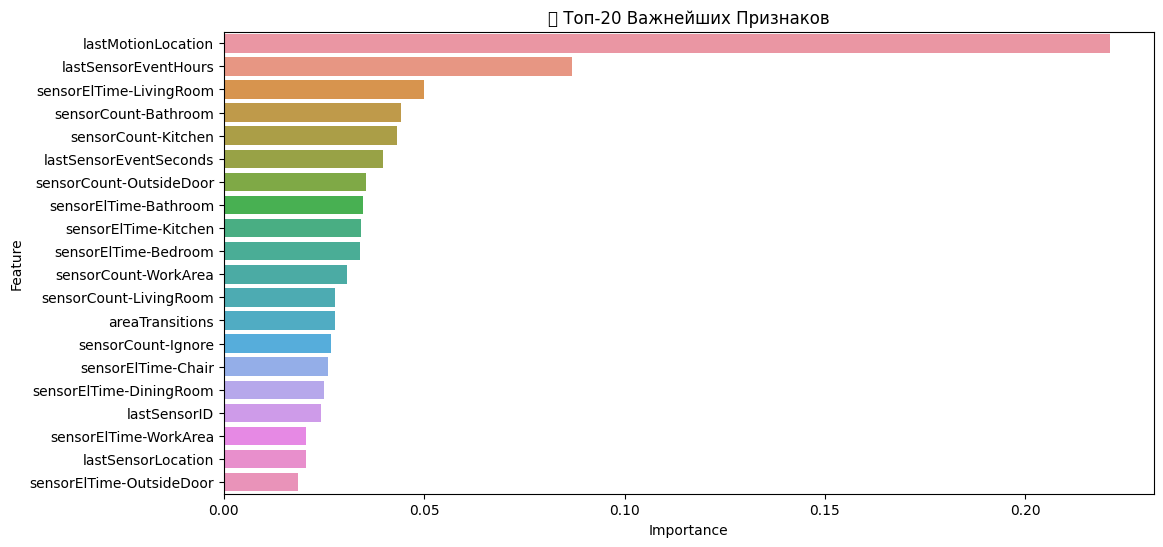

In [8]:
# Важность признаков
importances = model.feature_importances_
features = X.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature')
plt.title("🔍 Топ-20 Важнейших Признаков")
plt.show()

Давайте посмотрим, сколько ошибок было совершено

In [9]:
errors = X_test[y_pred != y_test]
print("Количество ошибок:", len(errors))

Количество ошибок: 25653


И в чем модель ошиблась

In [10]:
import numpy as np

errors_idx = np.where(y_pred != y_test)[0]
for i in errors_idx[:5]:  # покажем первые 5
    true_label = le.inverse_transform([y_test[i]])[0]
    pred_label = le.inverse_transform([y_pred[i]])[0]
    print(f" Истинное значение: {true_label} | Предсказание: {pred_label}")

 Истинное значение: Toilet | Предсказание: Other_Activity
 Истинное значение: Morning_Meds | Предсказание: Cook_Breakfast
 Истинное значение: Other_Activity | Предсказание: Sleep_Out_Of_Bed
 Истинное значение: Sleep | Предсказание: Other_Activity
 Истинное значение: Toilet | Предсказание: Other_Activity


Сравним распределение предсказанных классов с реальными (истинными)

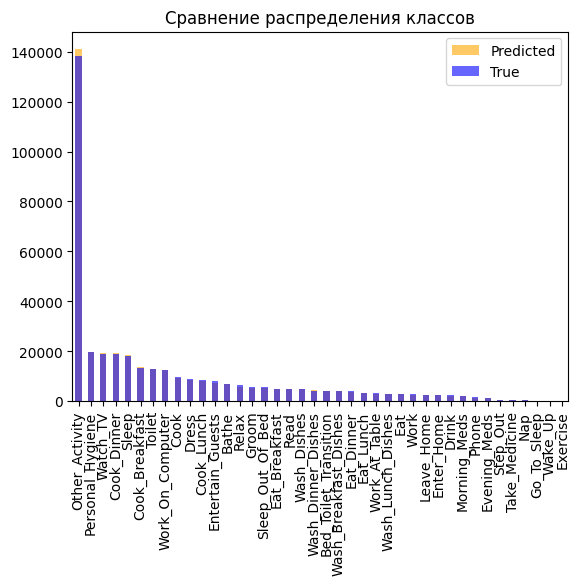

In [11]:
import pandas as pd

predicted_labels = le.inverse_transform(y_pred)
true_labels = le.inverse_transform(y_test)

pd.Series(predicted_labels).value_counts().plot(kind='bar', alpha=0.6, label='Predicted', color='orange')
pd.Series(true_labels).value_counts().plot(kind='bar', alpha=0.6, label='True', color='blue')
plt.title("Сравнение распределения классов")
plt.legend()
plt.show()

Как видно, модель хорошо "угадывает" распределение и не переоценивает или не недооценивает конкретные классы.

Это говорит о хорошем классовом балансе в предсказаниях. При этом видно, что она ммногое относит к Другой активности, это связано с перекосом в сырых данных.  

F1-Score (macro): 0.9221
F1-Score (weighted): 0.9302
ROC-AUC (One-vs-Rest): 0.9991


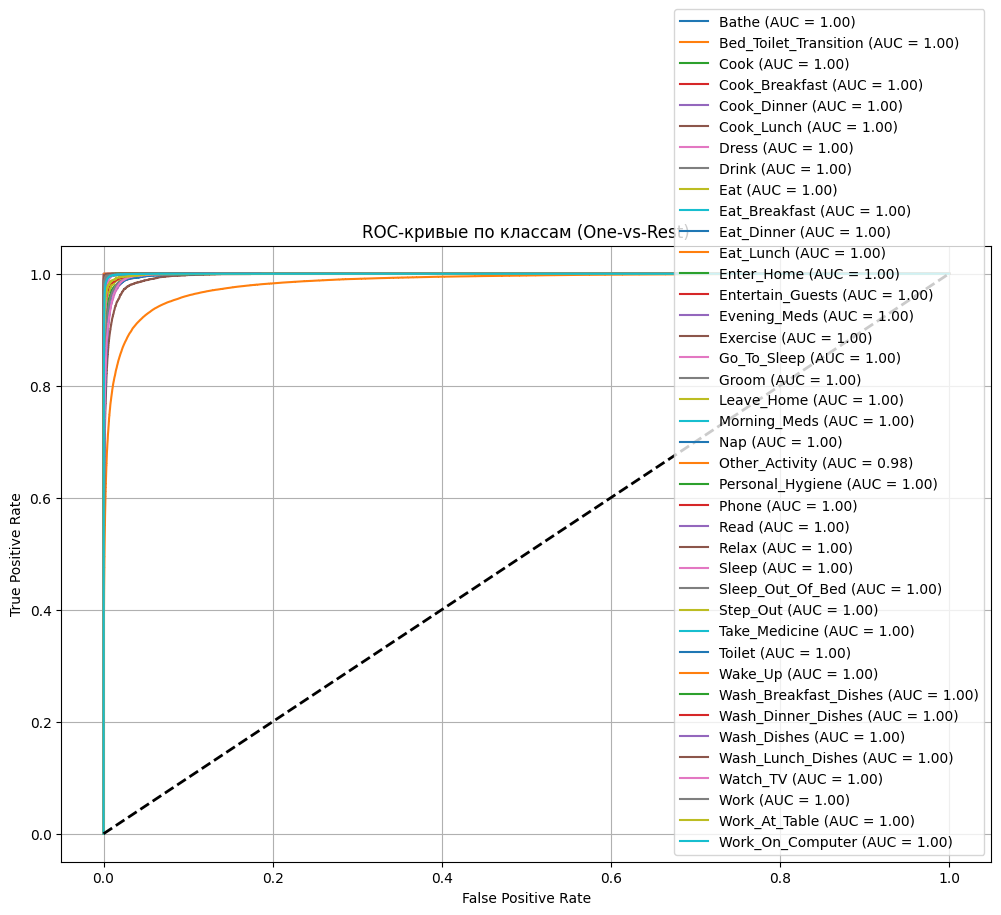

In [13]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# F1-Score
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"F1-Score (macro): {f1_macro:.4f}")
print(f"F1-Score (weighted): {f1_weighted:.4f}")

# ROC-AUC (One-vs-Rest)
# Бинаризация меток классов
y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))
y_proba = model.predict_proba(X_test)

roc_auc_ovr = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
print(f"ROC-AUC (One-vs-Rest): {roc_auc_ovr:.4f}")

# Визуализация ROC-кривых
plt.figure(figsize=(12, 8))

for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('ROC-кривые по классам (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()




F1-Score (macro): 0.9155
> Модель в среднем хорошо справляется с каждым классом, включая редкие активности. Это особенно ценно в задачах с несбалансированными данными.

F1-Score (weighted): 0.9267
> Модель очень хорошо предсказывает частые классы. Взвешенное среднее ещё выше, что говорит о сильной общей производительности.

Оценка ROC-AUC
Модель уверенно отделяет "положительные" классы от остальных.Кривые это подтверждают. Но нет ли у нашей модели переобучения? Посмотрим на t-SNE 

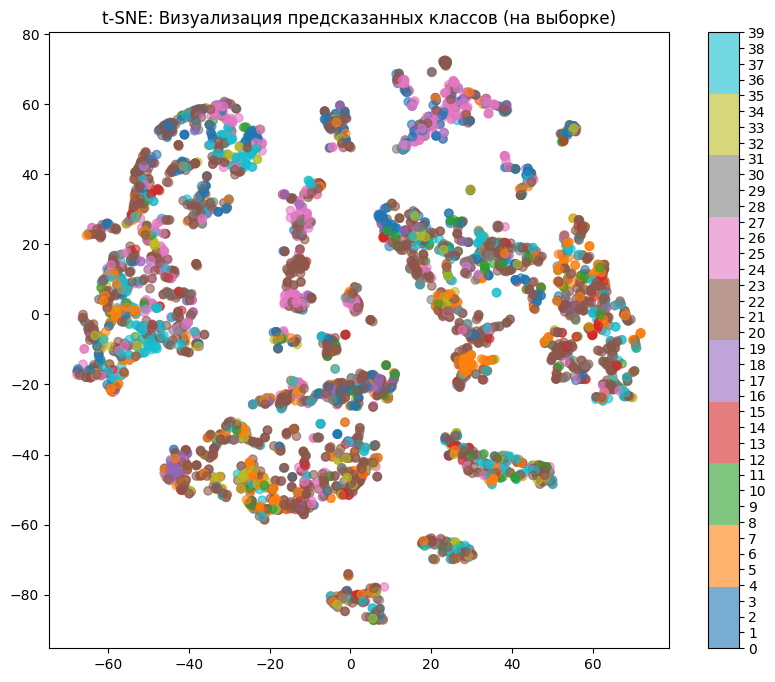

In [17]:
import numpy as np
from sklearn.manifold import TSNE

# Ограничим размер выборки для t-SNE
sample_size = 5000
idx = np.random.choice(len(X_test), size=sample_size, replace=False)

X_sample = X_test.iloc[idx]
y_sample = y_pred[idx]

# t-SNE на выборке
X_embedded = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_sample)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_sample, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, ticks=range(len(le.classes_)))
plt.title("t-SNE: Визуализация предсказанных классов (на выборке)")
plt.show()

Можно заметить, что классы выделяются, но цвета в них перемешаны. Это значит, что предсказанные классы не совпадают однозначно с кластерами в пространстве признаков.Возможно, модель путает близкие активности(возможно классы очень похожи по сенсорным данным)

## Параллельное выполнение алгоритма

Установим параллельную обработку в Optuna: в функции study.optimize() параметр n_jobs=-1 указывает на использование всех доступных процессоров для ускорения подбора гиперпараметров. Это позволит эффективно использовать многозадачность.

А также параллельное обучение в XGBoost: в параметре n_jobs=-1 - модель будет использовать все доступные процессоры для обучения.

Основная цель параллельного алгоритма — ускорить процесс подбора гиперпараметров и обучения модели за счет использования нескольких ядер процессора

In [7]:
# Разделение на признаки и целевую переменную
X = df_full.drop(columns=['activity'])  # признаки
y = df_full['activity']  # целевая переменная

# Кодирование меток
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


[I 2025-04-16 06:21:59,065] A new study created in memory with name: no-name-38874e84-c623-496b-b518-4b6bb4e0cb64


Запуск Optuna для подбора гиперпараметров...


[I 2025-04-16 06:32:57,309] Trial 3 finished with value: 0.7229871702963934 and parameters: {'n_estimators': 65, 'max_depth': 5, 'learning_rate': 0.08661349207462243, 'subsample': 0.6435624596098558, 'colsample_bytree': 0.7155506450412789}. Best is trial 3 with value: 0.7229871702963934.
[I 2025-04-16 06:33:37,322] Trial 6 finished with value: 0.798223752368068 and parameters: {'n_estimators': 63, 'max_depth': 6, 'learning_rate': 0.17146967187447243, 'subsample': 0.6943829313171721, 'colsample_bytree': 0.7749798201032756}. Best is trial 6 with value: 0.798223752368068.
[I 2025-04-16 06:36:43,773] Trial 2 finished with value: 0.8296968648240495 and parameters: {'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.19371917890856066, 'subsample': 0.8854770773347694, 'colsample_bytree': 0.8705907326598005}. Best is trial 2 with value: 0.8296968648240495.
[I 2025-04-16 06:37:15,442] Trial 5 finished with value: 0.6956737673124591 and parameters: {'n_estimators': 94, 'max_depth': 4, 'learn

Лучшие параметры: {'n_estimators': 147, 'max_depth': 7, 'learning_rate': 0.15284686514906254, 'subsample': 0.7398140794149067, 'colsample_bytree': 0.9867044769562372}
Обучение модели с лучшими параметрами...
⏱ Обучение заняло: 359.11 секунд.
Classification Report:
                       precision    recall  f1-score   support

                Bathe       0.97      0.98      0.98      6755
Bed_Toilet_Transition       0.93      0.96      0.95      4136
                 Cook       0.97      0.92      0.95      9776
       Cook_Breakfast       0.95      0.98      0.97     13229
          Cook_Dinner       0.95      0.98      0.97     19024
           Cook_Lunch       0.95      0.98      0.96      8388
                Dress       0.90      0.72      0.80      8722
                Drink       0.95      0.89      0.92      2317
                  Eat       0.98      0.94      0.96      2736
        Eat_Breakfast       0.93      0.94      0.93      4919
           Eat_Dinner       0.96      0.9

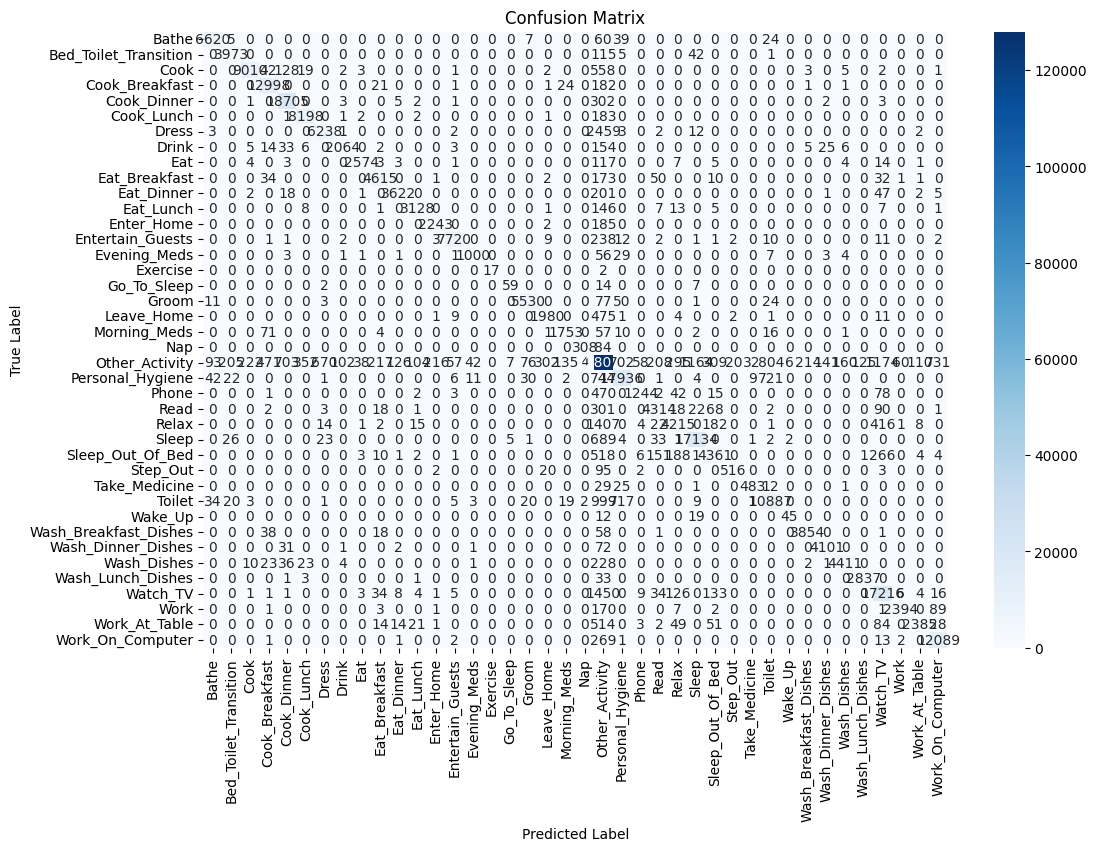

In [9]:

# Определение функции для подбора гиперпараметров с использованием Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'tree_method': 'hist',
        'use_label_encoder': False,
        'eval_metric': 'mlogloss',
        'n_jobs': -1  # поменяли на -1
    }

    X_sub_train, X_sub_val, y_sub_train, y_sub_val = train_test_split(
        X_train, y_train, test_size=0.3, stratify=y_train, random_state=42
    )

    model = XGBClassifier(**param)
    model.fit(X_sub_train, y_sub_train)
    score = model.score(X_sub_val, y_sub_val)
    return score

print("Запуск Optuna для подбора гиперпараметров...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, n_jobs=-1)  # используем все ядра процессора

print("Лучшие параметры:", study.best_params)

# Обучение модели с лучшими параметрами
best_params = study.best_params
best_params.update({
    'use_label_encoder': False,
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'random_state': 42,
    'n_jobs': -1  # Используем все процессоры для обучения
})

model = XGBClassifier(**best_params)

print("Обучение модели с лучшими параметрами...")
start = time.time()
model.fit(X_train, y_train)
end = time.time()
print(f"⏱ Обучение заняло: {end - start:.2f} секунд.")

# Оценка модели
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



F1-Score (macro): 0.9048
F1-Score (weighted): 0.9181
ROC-AUC (One-vs-Rest): 0.9988


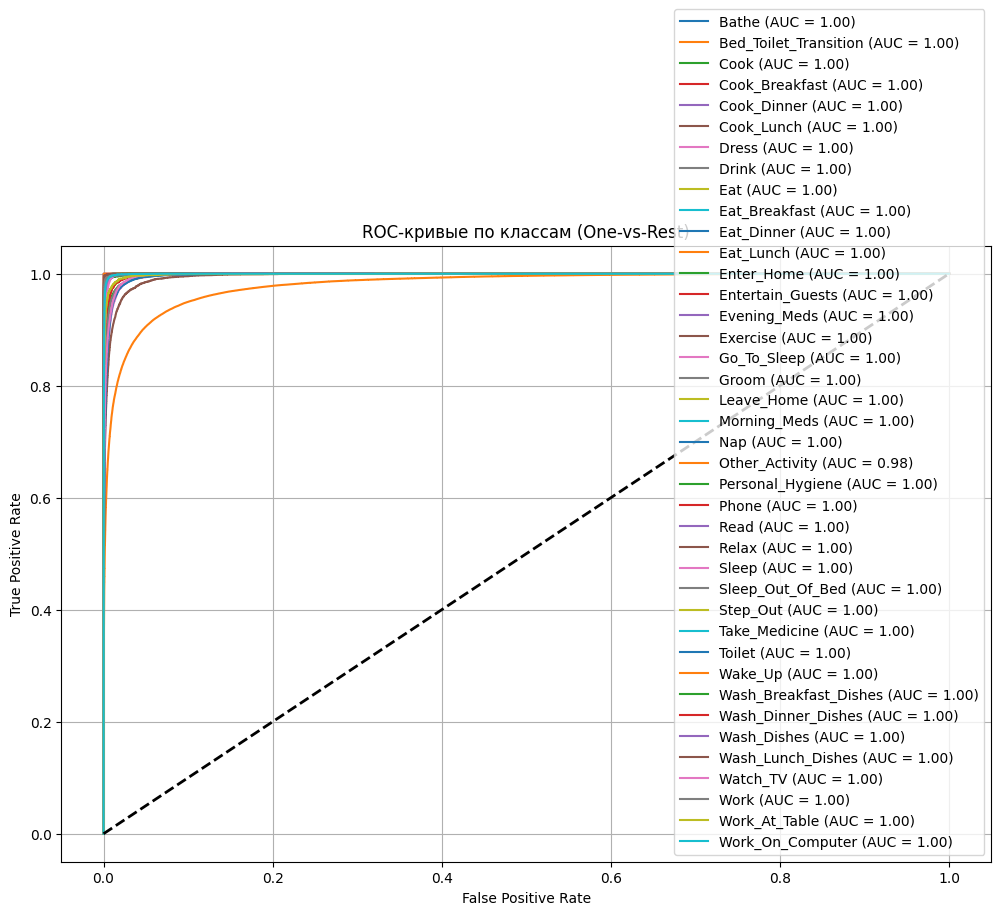

In [10]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Вычисление F1-Score и ROC-AUC
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"F1-Score (macro): {f1_macro:.4f}")
print(f"F1-Score (weighted): {f1_weighted:.4f}")

# ROC-AUC (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))
y_proba = model.predict_proba(X_test)

roc_auc_ovr = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
print(f"ROC-AUC (One-vs-Rest): {roc_auc_ovr:.4f}")

# Визуализация ROC-кривых
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('ROC-кривые по классам (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()